##Importación de las librerías

En primer lugar, importamos todas las librerías que utilizaremos, en especial las necesarias para la creación de la CNN, que se construirá con la librería Keras de Tensorflow

In [ ]:
import numpy as np 
import sklearn
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
from tqdm import tqdm
import cv2

## Procesamiento de los datos

Procedemos a leer los datos y crear nuestro target y predictores

In [ ]:
data = pd.read_csv('drive/MyDrive/Proyecto4_CienciaDatos/fer2013.csv')

In [ ]:
x_data = data['pixels']
y_data = data['emotion']

Y visualizamos la distribución de las clases. En específico, tenemos 7 emociones, cada una representada por un número
 

*   Anger: **0**
*   Disgust: **1**
*   Fear: **2**
*   Happy: **3**
*   Sad: **4**
*   Surprise: **5**
*   Neutral: **6**

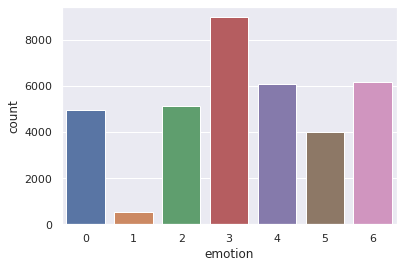

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)
plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/hist1.png', dpi=200)

Por medio ahora del método RandomOverSampler, se generarán elementos en las clases con pocos datos para tenerlas niveladas

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


Y graficamos nuevamente las clases para verificar que se encuentren balanceadas

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


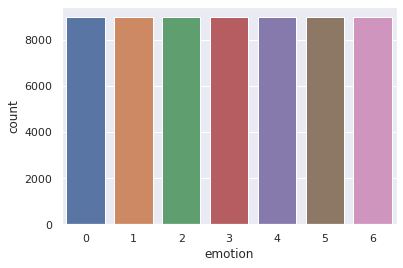

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(y_data)
plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/hist2.png', dpi=200)

Procesamos ahora los datos de las píxeles de las imágenes para convertirlos en matrices de numpy y poder trabajar con ellos

In [ ]:
x_data = pd.Series(x_data.flatten())

In [ ]:
X = []
for i in tqdm(range(len(x_data))):
  X.append(np.array(x_data.iloc[i].split(), dtype=float).reshape(48,48)/255)

100%|██████████| 62923/62923 [00:25<00:00, 2498.96it/s]


In [ ]:
x_data = np.array(X)

Y finalmente, ajustamos las dimensiones de nuestros datasets

In [ ]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [ ]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

##Arquitectura del modelo

Por medio del método train_test_split, escogemos aleatoriamente un 10% de nuestros datos para que sean de testeo

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

Y definimos nuestra CNN de 20 capas, donde priman las capas Conv2D, y las de MaxPooling2D

In [ ]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Visualizamos nuestro modelo en una gráfica esquemática

In [ ]:
tf.keras.utils.plot_model(model, to_file = "/content/drive/MyDrive/Proyecto4_CienciaDatos/images/model.png", show_shapes = True, show_dtype = True)

Y definimos nuestro criterio y optimizador

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

Para terminar, reshapeamos nuevamente nuestro target para poder realizar el análisis de predicciones de mejor manera

In [ ]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [ ]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

##Entrenamiento del modelo

Y finalmente entrenamos con 30 épocas

In [ ]:
history = model.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 1136s 640ms/step - loss: 1.7322 - accuracy: 0.3218 - val_loss: 1.4526 - val_accuracy: 0.4602
Epoch 2/30
1770/1770 [==============================] - 1135s 641ms/step - loss: 1.3961 - accuracy: 0.4659 - val_loss: 1.1987 - val_accuracy: 0.5576
Epoch 3/30
1770/1770 [==============================] - 1140s 644ms/step - loss: 1.2135 - accuracy: 0.5370 - val_loss: 1.0718 - val_accuracy: 0.5848
Epoch 4/30
1770/1770 [==============================] - 1136s 642ms/step - loss: 1.0960 - accuracy: 0.5799 - val_loss: 0.9952 - val_accuracy: 0.6272
Epoch 5/30
1770/1770 [==============================] - 1141s 645ms/step - loss: 1.0051 - accuracy: 0.6180 - val_loss: 0.9462 - val_accuracy: 0.6345
Epoch 6/30
1770/1770 [==============================] - 1143s 646ms/step - loss: 0.9244 - accuracy: 0.6466 - val_loss: 0.9003 - val_accuracy: 0.6641
Epoch 7/30
1770/1770 [==============================] - 1127s 637ms/step - loss: 0.8569 - accuracy: 0.6745

Evaluamos ahora nuestro modelo con el set de práctica

In [ ]:
print("Accuracy: {:.2f}%".format(model.evaluate(x_test,y_test)[1]*100))

197/197 [==============================] - 32s 163ms/step - loss: 0.8770 - accuracy: 0.8263
Accuracy: 82.63%


E imprimimos el f1_score correspondiente

In [ ]:
y_pred = model.predict(x_test)
Y_test = []
Y_pred = []

for i in range(len(y_pred)):
    Y_pred.append(np.argmax(y_pred[i]))
    Y_test.append(np.argmax(y_test[i]))

print('f1_score: {:.4f}'.format(sklearn.metrics.f1_score(Y_test, Y_pred, average='weighted')))

f1_score: 0.8269


Podemos, de igual manera, mostrar y guardar las gráficas que muestran la evolución del modelo a través de las épocas. En especial las del *Accuracy* y el *Loss*

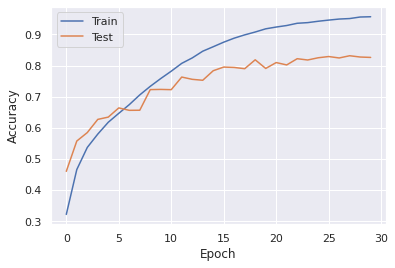

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/acc.png', dpi=200)

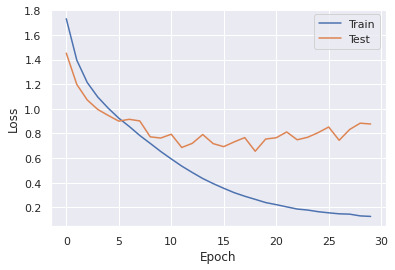

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/loss.png', dpi=200)

Para concluir, guardamos la arquitectura de nuestro modelo, así como los pesos, para posteriores usos

In [ ]:
model_json = model.to_json()  
with open("/content/drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/model/model.json", "w") as json_file:  
    json_file.write(model_json)  
model.save("drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/model/model.h5") 

Y guardamos los datos del *X_test*, *Y_test* y *Y_pred* para posteriores análisis.

In [ ]:
X_test = []

for x in x_test:
  X_test.append(x.reshape(48*48))
X_test = np.array(X_test)

In [ ]:
np.savetxt('/content/drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/X_test.txt', X_test)
np.savetxt('/content/drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/Y_test.txt', Y_test)
np.savetxt('/content/drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/Y_pred.txt', Y_pred)